In [1]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns
from matplotlib.lines import Line2D
from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display
import matplotlib as mpl

# Configure global font size settings
mpl.rcParams.update({
    'font.size': 25,  # Default font size for titles, labels, and tick labels
    'axes.labelsize': 20,  # Font size for axis labels
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20,  # Font size for y-axis tick labels
    'legend.fontsize': 20,  # Font size for the legend
    'legend.title_fontsize': 20  # Font size for the legend title

})


# the graphs this script will generate:
## 1. local quality:
            x:  deletion_factor: fix user_input_size
            x:  complaint_ratio: fix user_input_size
            y:  fix rate + confirm preserve rate + global accuracy (before after)
## 2.3 strat comparison:
      x: user input size (fix complaint ratio, fix deletion factor)
      y: runtime, global_accuracy, fix rate, confirm preserve rate

In [2]:
line_color_assignment_dict={'greedy':'g','entropy':'r'}
# line_color_assignment_dict={'greedy':'g','entropy':'r', 'brute_force': 'b'}

# scatter_shape_assignment_dict = {20: 'o', 40:'D', 80:'^', 160:'*', 320:'s'}
scatter_shape_assignment_dict = {10: 'o', 30:'D', 50:'^', 70:'*', 90:'>',110:'s', 130: 'v'}


# 'o' - Circle (default)
# 's' - Square
# 'D' - Diamond
# '^' - Upward-pointing triangle
# 'v' - Downward-pointing triangle
# '<' - Left-pointing triangle
# '>' - Right-pointing triangle
# 'p' - Pentagon
# 'H' - Hexagon
# '+' - Plus sign
# '*' - Asterisk
# 'x' - X symbol
# '|' - Vertical bar
# '_' - Horizontal bar
# '.' - Point
# ',' - Pixel


In [3]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    treefiles = glob.glob(f'{directory}*tree_*')
    num_trees_per_strat = len(treefiles)
    for i in range(0, int(num_trees_per_strat)):
        for f in glob.glob(f'{directory}*tree_*_{i}*'):
            file = open(f)
            dot_string = file.read()
            print(f)
#             print(dot_string)
            graph = pydot.graph_from_dot_data(dot_string)[0]
            view_pydot(graph)
            print('\n')
            
def show_stats(directory):
    fs = glob.glob(f'{directory}*/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=10)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    strat_list = list(df['strat'].unique())
    strat_list.sort()
        
    ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].unique()[0]), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend(fontsize=14,title_fontsize=15)
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat',fontsize=13,title_fontsize=15)
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='Strat',fontsize=14,title_fontsize=15)
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf")
    plt.show()

def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict,
               scatter_shape_assignment_dict,
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
    groups = df.groupby(['strat', 'user_input_size'])
        
    unique_colors = set()  # Initialize sets to keep track of added labels
    unique_markers = set()
    color_legend_entries= []
    marker_legend_entries = []
    
    for (strat, size), group in groups:
#         print(f"strat:{strat}")
        color = color_assignment_dict.get(strat)
        if(color not in unique_colors):
            unique_colors.add(color)
            color_legend_entries.append(Line2D([0], [0], marker='s', color='w',
                                            markerfacecolor=color, markersize=10, label=strat))
        marker = scatter_shape_assignment_dict.get(size)
        if(marker not in unique_markers):
            unique_markers.add(marker)
#             print(marker)
            marker_legend_entries.append(Line2D([0], [0], marker=marker, color='w', 
                                            markerfacecolor='black', markersize=10, label=size))
        ax.scatter(group[x], group[y], color=color, label=size, marker=marker, s=70)

    for (strat, size), group in groups:
        color = color_assignment_dict.get(strat)
        ax.plot(group[x], group[y], color=color, label=strat)

    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    

    # Add the custom legends to the figure at desired locations within the axes
#     fig.legend(handles=marker_legend_entries, loc='upper right',title='input size')
#     fig.legend(handles=color_legend_entries, loc='upper right', bbox_to_anchor=(0.85, 0.85),title='strat')

    ax.set_xlabel(xlabel+'')
    ax.set_ylabel(ylabel)
#     ax.set_title(title)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/2_algo_compare_{title}.pdf', format='pdf',bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close(fig)
    

def line_plots_legends_only(df, color_assignment_dict, scatter_shape_assignment_dict):
    fig, ax = plt.subplots()
        
    # Remove background grid
    ax.set_axis_off()

    # Create the custom legends
    color_legend_entries = []
    marker_legend_entries = []

    for strat, color in color_assignment_dict.items():
        color_legend_entries.append(Line2D([0], [0], marker='s', color='w',
                                          markerfacecolor=color, markersize=18, label=strat))

    for size, marker in scatter_shape_assignment_dict.items():
        marker_legend_entries.append(Line2D([0], [0], marker=marker, color='w', 
                                          markerfacecolor='black', markersize=18, label=size))
    
    
    # Add the custom legends to the figure at desired locations within the axes
    fig.legend(handles=marker_legend_entries, loc='upper center', title='input size', 
               ncol=8,fontsize=14,bbox_to_anchor=(0.5,0.75))
    fig.legend(handles=color_legend_entries, loc='upper center', title='strat', ncol=8)
    plt.savefig(f'graph_pdfs/2_algo_compare_legend_only.pdf', format='pdf',  
                bbox_inches='tight',pad_inches=0.2)
    plt.show()
    plt.close(fig)


In [5]:
# 3 strat comparison

# df_2_strats= show_stats('../experiment_results_folders/all_lf_experiments_930/2_algo/')
df_2_strats= show_stats('../experiment_results_folders/2_algo_absolute_del_1017/2_algo/')

# /home/opc/chenjie/RBBM/rbbm_src/experiment_results_folders

In [6]:
df_2_strats.shape

(5086, 31)

In [12]:
df_2_strats.head()

,strat,seed,pickle_file_name,table_name,timestamp_str,deletion_type,deletion_absolute_threshold,rbbm_runtime,bbox_runtime,avg_tree_size_increase,user_input_size,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
0,naive,1052,/home/opc/chenjie/RBBM/rbbm_src/labelling_func_src/src/pickled_funcs_720,youtube,20231018033805,absolute,4,0.027,5.034,0.666667,10,0.1,1,9,0.821,0.0,1.0,0.823,1412,1412,30,0.5,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,1052,/home/opc/chenjie/RBBM/rbbm_src/labelling_func_src/src/pickled_funcs_720,youtube,20231018033817,absolute,4,0.029,4.945,0.666667,10,0.1,1,9,0.821,0.0,1.0,0.823,1412,1412,30,0.5,30,30,False,False,undefined,1,1,True,0.0
0,naive,565,/home/opc/chenjie/RBBM/rbbm_src/labelling_func_src/src/pickled_funcs_720,youtube,20231018033828,absolute,6,0.026,4.968,0.666667,10,0.1,1,9,0.821,0.0,1.0,0.821,1412,1412,30,0.5,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,565,/home/opc/chenjie/RBBM/rbbm_src/labelling_func_src/src/pickled_funcs_720,youtube,20231018033840,absolute,6,0.027,4.729,0.666667,10,0.1,1,9,0.821,0.0,1.0,0.821,1412,1412,30,0.5,30,30,False,False,undefined,1,1,True,0.0
0,naive,1970,/home/opc/chenjie/RBBM/rbbm_src/labelling_func_src/src/pickled_funcs_720,youtube,20231018033852,absolute,8,0.027,4.938,0.733333,10,0.1,1,9,0.821,0.0,1.0,0.821,1412,1412,30,0.5,30,30,False,False,undefined,1,1,True,0.0


In [7]:
df = df_2_strats[['strat','rbbm_runtime','bbox_runtime','deletion_factor','avg_tree_size_increase','user_input_size','complaint_ratio','global_accuracy','fix_rate','confirm_preserve_rate','new_global_accuracy']]
df_grouped = df.groupby(['strat','user_input_size', 'complaint_ratio', 'deletion_absolute_threshold']).mean().reset_index()
df_grouped.loc[df_grouped['strat']=='information_gain', 'strat'] = 'entropy'
df_grouped.loc[df_grouped['strat']=='naive', 'strat'] = 'greedy'
df_grouped.loc[df_grouped['strat']=='optimal', 'strat'] = 'brute_force'


In [8]:
df_grouped['strat'].unique()

array(['entropy', 'greedy'], dtype=object)

In [9]:
deletion_factors = [0, 0.3, 0.5]
# graphs_yaxis = ['new_global_accuracy', 'avg_tree_size_increase', 'fix_rate', 'confirm_preserve_rate', 'rbbm_runtime']
graphs_yaxis = ['new_global_accuracy', 'fix_rate', 'confirm_preserve_rate']
beauti_name = ['new global acc.', 'fix rate', 'preserv. rate']
renaming_dict = dict(zip(graphs_yaxis, beauti_name))

In [10]:
renaming_dict


{'new_global_accuracy': 'new global acc.',
 'fix_rate': 'fix rate',
 'confirm_preserve_rate': 'preserv. rate'}

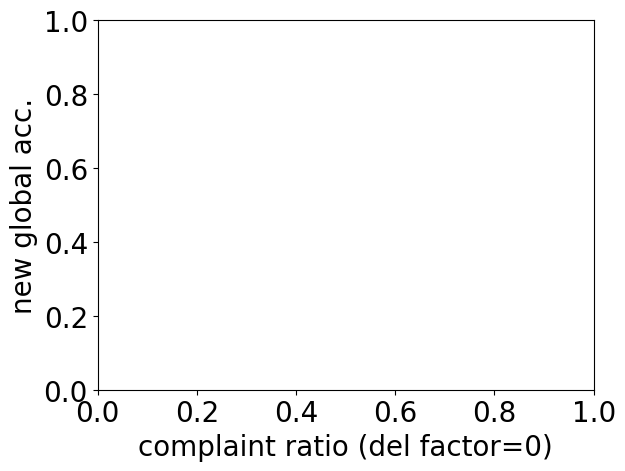

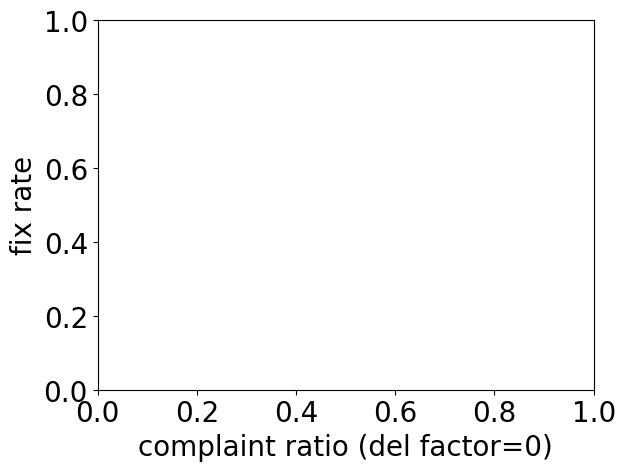

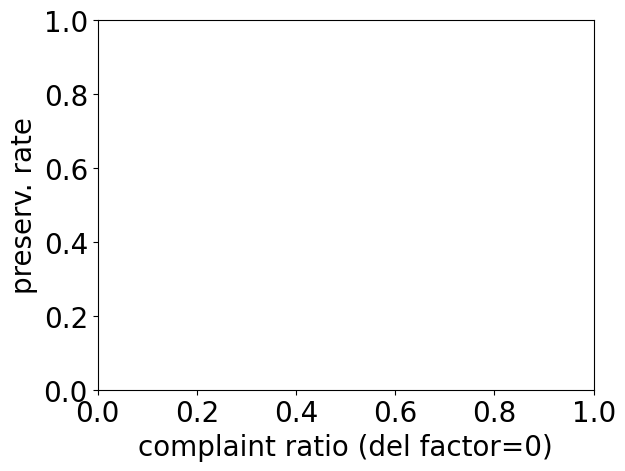

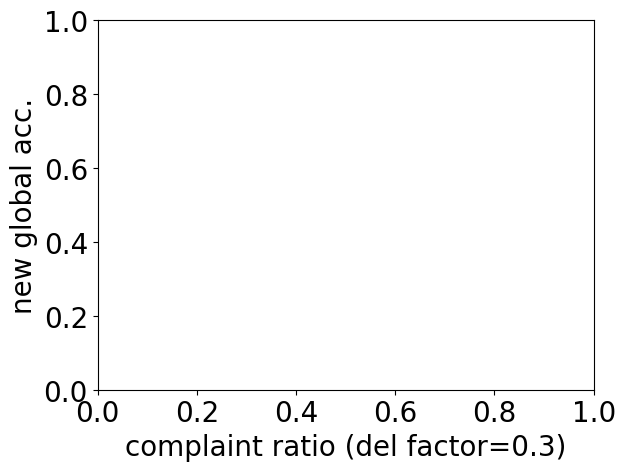

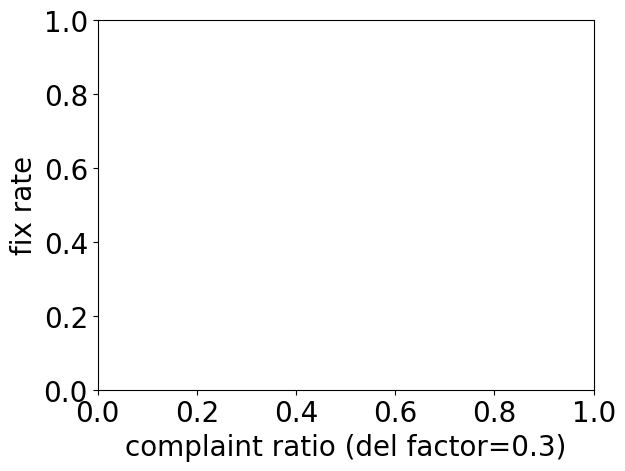

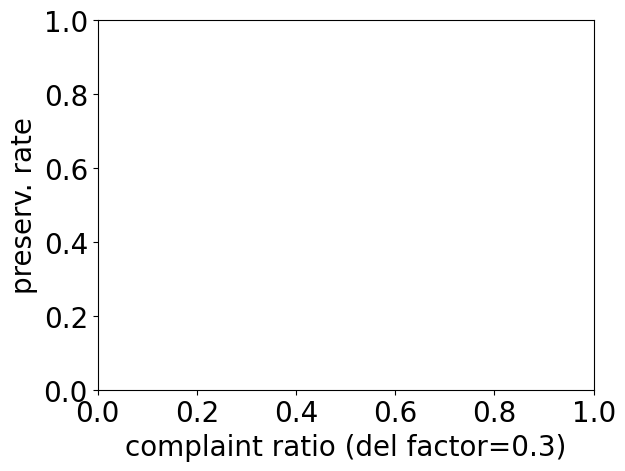

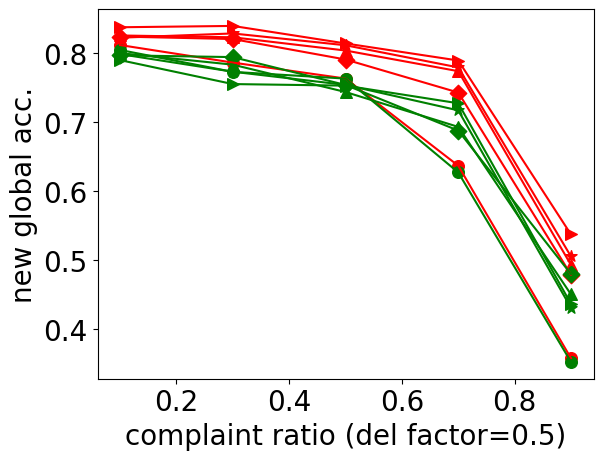

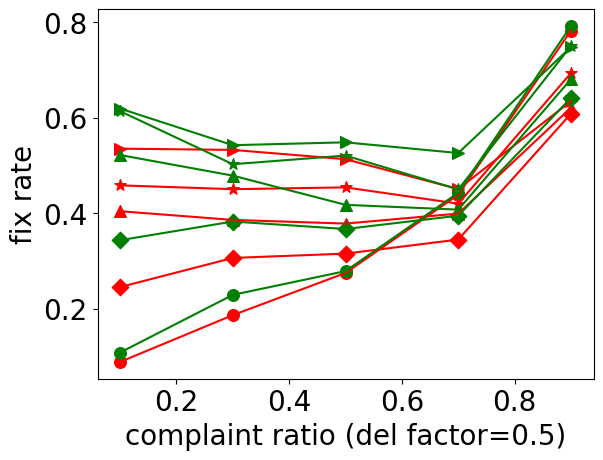

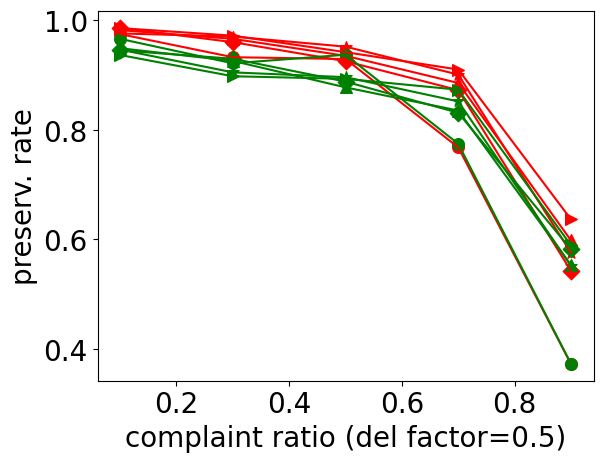

In [11]:
for del_f in deletion_factors:
    df_deletion_fixed = df_grouped[(df_grouped['deletion_factor']==del_f)]
    for y in graphs_yaxis:
        ylabel = renaming_dict[y]
        line_plots(df=df_deletion_fixed, 
        x='complaint_ratio', 
        y=y, 
        xlabel=f'complaint ratio (del factor={del_f})',
        ylabel=ylabel,
        title=f'{y} (deletion_factor={del_f})', 
        color_assignment_dict=line_color_assignment_dict,
       scatter_shape_assignment_dict=scatter_shape_assignment_dict
       )

In [35]:
df_deletion_fixed['user_input_size'].unique()

array([ 10,  30,  50,  70,  90, 110, 130])

In [36]:
df_smaller = df_deletion_fixed[df_deletion_fixed['user_input_size'].isin([30,70, 110])]

In [37]:
line_color_assignment_dict = {'greedy':'#fe4a49', 'entropy':'#2ab7ca'}
scatter_shape_assignment_dict = {10: 'o', 30:'D', 50:'^', 70:'*', 90:'>',110:'s', 130: 'v'}




# 'o' - Circle (default)
# 's' - Square
# 'D' - Diamond
# '^' - Upward-pointing triangle
# 'v' - Downward-pointing triangle
# '<' - Left-pointing triangle
# '>' - Right-pointing triangle
# 'p' - Pentagon
# 'H' - Hexagon
# '+' - Plus sign
# '*' - Asterisk
# 'x' - X symbol
# '|' - Vertical bar
# '_' - Horizontal bar
# '.' - Point
# ',' - Pixel


# custom_palette = ['#2ab7ca','#fed766', '#fe4a49', 'red']
# strats = ['entropy', 'brute force', 'greedy', 'global acc.']

In [45]:
df_deletion_fixed = df_grouped[(df_grouped['deletion_factor']==0)]
df_smaller = df_deletion_fixed[df_deletion_fixed['user_input_size'].isin([30,70, 110])]

In [46]:
df_smaller

,strat,user_input_size,complaint_ratio,deletion_factor,rbbm_runtime,bbox_runtime,avg_tree_size_increase,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy
20,entropy,30,0.1,0.0,0.095880,4.981720,0.970667,0.821,0.226520,0.988160,0.817120
24,entropy,30,0.3,0.0,0.116840,4.923680,1.229333,0.821,0.288760,0.984720,0.830040
28,entropy,30,0.5,0.0,0.104840,4.988360,1.240000,0.821,0.256080,0.954600,0.805640
32,entropy,30,0.7,0.0,0.096080,4.950600,1.162667,0.821,0.318080,0.906720,0.790880
36,entropy,30,0.9,0.0,0.099000,5.156440,1.184000,0.821,0.626720,0.479960,0.473520
60,entropy,70,0.1,0.0,0.481708,5.012500,1.394444,0.821,0.392958,0.976833,0.817292
64,entropy,70,0.3,0.0,0.521500,4.731125,1.813889,0.821,0.428542,0.978792,0.833375
68,entropy,70,0.5,0.0,0.521750,4.933917,1.911111,0.821,0.441708,0.968958,0.843250
72,entropy,70,0.7,0.0,0.500292,4.808083,1.950000,0.821,0.404750,0.932583,0.801250
76,entropy,70,0.9,0.0,0.473875,4.746542,1.780556,0.821,0.592125,0.672542,0.593083


In [48]:
y

'rbbm_runtime'

In [78]:
scatter_shape_assignment_dict = {30:'v', 70:'o', 110:'P'}


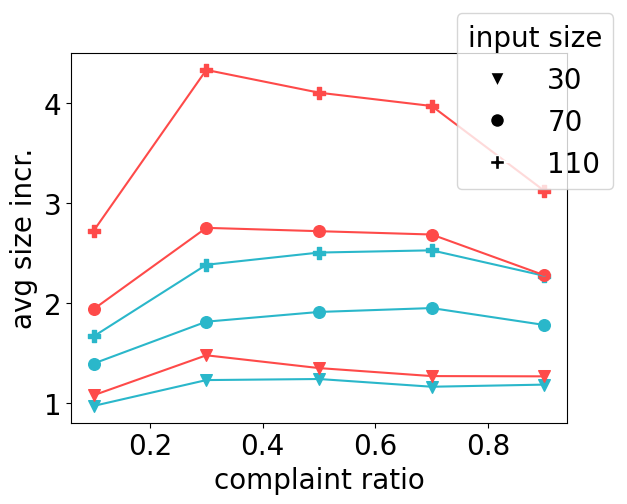

In [103]:
line_plots(df=df_smaller, 
x='complaint_ratio', 
y='avg_tree_size_increase', 
xlabel=f'complaint ratio',
ylabel='avg size incr.',
title=f'complaint ratio vs avg size (lf)', 
color_assignment_dict=line_color_assignment_dict,
scatter_shape_assignment_dict=scatter_shape_assignment_dict
)

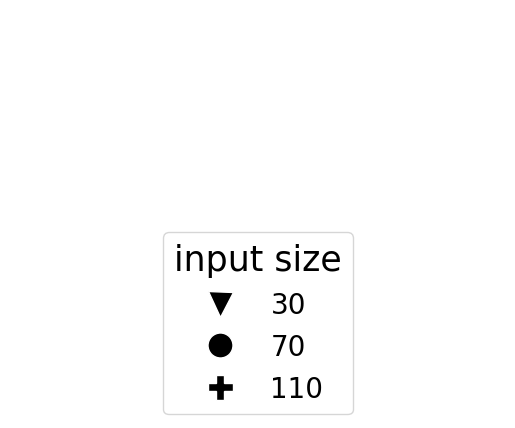

In [80]:
line_plots_legends_only(df=df_deletion_fixed, 
#     x='complaint_ratio', 
#     y='new_global_accuracy', 
#     xlabel='complaint_ratio', 
#     ylabel='new_global_accuracy',
#     title="lengends_only",
    color_assignment_dict=line_color_assignment_dict,
   scatter_shape_assignment_dict=scatter_shape_assignment_dict
   )

In [ ]:
!zip graph_pdfs/complaint_ratios_more_reps.zip graph_pdfs/2_algo_compare_* 